In [15]:
%%capture
%pip install torch
%pip install torchvision
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install scipy
%pip install pyvista ipyvtklink pyvistaqt

# Importing data

In [16]:
import pickle
from pathlib import Path
from typing import Callable, Dict, Tuple, Union
import sympy.core as _  # forces the attribute to exist
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output, display
import math
from gauss_newton import GaussNewtonPINNOptimizer, GaussNewtonStepResult


def _select_device() -> torch.device:
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


DEVICE = _select_device()
DEFAULT_DTYPE = torch.float32 if DEVICE.type == "mps" else torch.float64
torch.set_default_dtype(DEFAULT_DTYPE)
torch.manual_seed(42)

DATA_DIR = Path("new data") # CHANGE BETWEEN CYLINDER AND SHOCK TESTS
PRIMITIVE_LABELS = ["rho", "vx", "vy", "vz", "Bx", "By", "Bz", "p"]
RAW_FIELD_KEYS = ["rho", "u1", "u2", "u3", "b1", "b2", "b3", "p"]


def load_snapshots(data_dir: Path = DATA_DIR) -> Dict[float, Dict[str, np.ndarray]]:
    snapshots: Dict[float, Dict[str, np.ndarray]] = {}
    for path in sorted(data_dir.glob("data2D_t_*.pkl")):
        with open(path, "rb") as fh:
            payload = pickle.load(fh)
        time_value = float(payload["time"])
        centers = np.asarray(payload["centers"], dtype=np.float64)
        fields = payload["cell_data"]
        primitives = np.stack([
            np.asarray(fields[key], dtype=np.float64) for key in RAW_FIELD_KEYS
        ], axis=1)
        x_unique = np.unique(centers[:, 0])
        y_unique = np.unique(centers[:, 1])
        nx = x_unique.size
        ny = y_unique.size
        grid = np.empty((ny, nx, primitives.shape[1]), dtype=np.float64)
        ix = np.searchsorted(x_unique, centers[:, 0])
        iy = np.searchsorted(y_unique, centers[:, 1])
        grid[iy, ix] = primitives
        snapshots[time_value] = {
            "x": x_unique,
            "y": y_unique,
            "grid": grid,
            "centers": centers,
        }
    if not snapshots:
        raise RuntimeError(f"No snapshot files found in {data_dir}")
    return snapshots


SNAPSHOTS = load_snapshots()
AVAILABLE_TIMES = np.array(sorted(SNAPSHOTS.keys()), dtype=np.float64)
X_DOMAIN = (SNAPSHOTS[AVAILABLE_TIMES[0]]["x"][0], SNAPSHOTS[AVAILABLE_TIMES[0]]["x"][-1])
Y_DOMAIN = (SNAPSHOTS[AVAILABLE_TIMES[0]]["y"][0], SNAPSHOTS[AVAILABLE_TIMES[0]]["y"][-1])
T_DOMAIN = (0.0, 0.4)
condition_times = [0.0, 0.2, 0.4]


def _resolve_time_key(t: Union[float, torch.Tensor, np.ndarray]) -> float:
    t_scalar = float(t.detach().cpu().item() if isinstance(t, torch.Tensor) else np.asarray(t).item())
    matches = np.isclose(AVAILABLE_TIMES, t_scalar, atol=1e-12)
    if not np.any(matches):
        raise ValueError(
            f"Requested time {t_scalar} not found. Available times: {AVAILABLE_TIMES.tolist()}"
        )
    return float(AVAILABLE_TIMES[matches][0])


def _prepare_xy(xy: Union[np.ndarray, torch.Tensor]) -> Tuple[np.ndarray, Tuple[int, ...]]:
    if isinstance(xy, torch.Tensor):
        arr = xy.detach().cpu().numpy()
    else:
        arr = np.asarray(xy, dtype=np.float64)
    arr = np.atleast_2d(arr).astype(np.float64)
    original_shape = tuple(arr.shape)
    flat = arr.reshape(-1, 2)
    return flat, original_shape


def _bilinear_lookup(snapshot: Dict[str, np.ndarray], xy: np.ndarray) -> np.ndarray:
    x_grid = snapshot["x"]
    y_grid = snapshot["y"]
    field = snapshot["grid"]
    nx = x_grid.size
    ny = y_grid.size
    x = np.clip(xy[:, 0], x_grid[0], x_grid[-1])
    y = np.clip(xy[:, 1], y_grid[0], y_grid[-1])
    ix1 = np.clip(np.searchsorted(x_grid, x, side="right") - 1, 0, nx - 2)
    iy1 = np.clip(np.searchsorted(y_grid, y, side="right") - 1, 0, ny - 2)
    ix2 = ix1 + 1
    iy2 = iy1 + 1
    x1 = x_grid[ix1]
    x2 = x_grid[ix2]
    y1 = y_grid[iy1]
    y2 = y_grid[iy2]
    tx = np.divide(x - x1, x2 - x1, out=np.zeros_like(x), where=(x2 - x1) != 0)
    ty = np.divide(y - y1, y2 - y1, out=np.zeros_like(y), where=(y2 - y1) != 0)
    c11 = field[iy1, ix1]
    c21 = field[iy1, ix2]
    c12 = field[iy2, ix1]
    c22 = field[iy2, ix2]
    interp = (
        (1 - tx)[:, None] * (1 - ty)[:, None] * c11
        + tx[:, None] * (1 - ty)[:, None] * c21
        + (1 - tx)[:, None] * ty[:, None] * c12
        + tx[:, None] * ty[:, None] * c22
    )
    return interp


def cond(
    t: Union[float, torch.Tensor, np.ndarray],
    xy: Union[np.ndarray, torch.Tensor],
    *,
    device: torch.device = None,
    as_tensor: bool = True,
) -> Union[np.ndarray, torch.Tensor]:
    xy_flat, original_shape = _prepare_xy(xy)
    if isinstance(t, torch.Tensor):
        t_arr = np.asarray(t.detach().cpu().numpy()).reshape(-1)
    else:
        t_arr = np.asarray(t, dtype=np.float64).reshape(-1)
    if t_arr.size == 1:
        t_arr = np.full(xy_flat.shape[0], float(t_arr[0]), dtype=np.float64)
    if t_arr.size != xy_flat.shape[0]:
        raise ValueError("Time array must be scalar or match the number of query points")
    outputs = np.zeros((xy_flat.shape[0], len(PRIMITIVE_LABELS)), dtype=np.float64)
    for time_value in np.unique(t_arr):
        time_key = _resolve_time_key(time_value)
        mask = np.isclose(t_arr, time_value)
        outputs[mask] = _bilinear_lookup(SNAPSHOTS[time_key], xy_flat[mask])
    if original_shape == ():
        reshaped = outputs.reshape(len(PRIMITIVE_LABELS),)
    else:
        target_shape = original_shape[:-1] if original_shape[-1] == 2 else original_shape
        reshaped = outputs.reshape(target_shape + (len(PRIMITIVE_LABELS),))
    if not as_tensor:
        return reshaped
    target_device = device or DEVICE
    return torch.as_tensor(reshaped, device=target_device, dtype=torch.get_default_dtype())


def plot_reference_profiles(times=(0.0, 0.2, 0.4), field="rho"):
    field_idx = PRIMITIVE_LABELS.index(field)
    fig, axes = plt.subplots(1, len(times), figsize=(5 * len(times), 4), sharex=True, sharey=True)
    axes = np.atleast_1d(axes)
    for ax, t in zip(axes, times):
        time_key = _resolve_time_key(t)
        snapshot = SNAPSHOTS[time_key]
        data = snapshot["grid"][..., field_idx]
        pcm = ax.pcolormesh(snapshot["x"], snapshot["y"], data, shading="auto", cmap="viridis")
        fig.colorbar(pcm, ax=ax, shrink=0.8, label=field)
        ax.set_title(f"t={t:.3f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    fig.suptitle(f"Reference {field} snapshots")
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig



# RMHD residual helpers

In [18]:
from RMHDEquations2D import primitives_to_conserved, flux_x, flux_y


def _partial_derivative(outputs: torch.Tensor, coords: torch.Tensor, dim: int) -> torch.Tensor:
    if outputs.ndim == 0:
        raise ValueError("outputs must have at least one dimension")

    outputs = outputs.reshape(-1, outputs.shape[-1])

    grads = []
    for component in range(outputs.shape[1]):
        grad = torch.autograd.grad(
            outputs[:, component].sum(),
            coords,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads.append(grad[:, dim])
    return torch.stack(grads, dim=1)


def rmhd_residual(primitives: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")

    conserved = primitives_to_conserved(primitives, gamma=5 / 3)
    flux_x_term = flux_x(primitives, gamma=5 / 3)
    flux_y_term = flux_y(primitives, gamma=5 / 3)
    dU_dt = _partial_derivative(conserved, coords, dim=2)
    dF_dx = _partial_derivative(flux_x_term, coords, dim=0)
    dG_dy = _partial_derivative(flux_y_term, coords, dim=1)
    return dU_dt + dF_dx + dG_dy



In [19]:
from jacobians import compute_M, compute_AX, compute_AY


def jacobian_residual(primitives: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")

    M = compute_M(primitives)
    AX = compute_AX(primitives)
    AY = compute_AY(primitives)
    dP_dx = _partial_derivative(primitives, coords, dim=0).unsqueeze(-1)
    dP_dy = _partial_derivative(primitives, coords, dim=1).unsqueeze(-1)
    dP_dt = _partial_derivative(primitives, coords, dim=2).unsqueeze(-1)
    return (M @ dP_dt + AX @ dP_dx + AY @ dP_dy).squeeze(-1)



# Architecture

In [20]:
class TrainableTanh(nn.Module):
    def __init__(self, init_gain=1.0, init_bias=0.0):
        super().__init__()
        self.log_gain = nn.Parameter(torch.tensor(float(np.log(init_gain))))
        self.bias = nn.Parameter(torch.tensor(init_bias))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gain = torch.exp(self.log_gain)  # keep gain positive
        return torch.tanh(gain * x + self.bias)

In [21]:

class PINN(nn.Module):
    def __init__(self, input_dim: int = 3, output_dim: int = 8, width: int = 16, depth: int = 12, activation=TrainableTanh):
        super().__init__()
        if depth < 1:
            raise ValueError("depth must be at least 1")
        self.activation = activation()
        layers = [nn.Linear(input_dim, width)]
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(width, output_dim)
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        x = coords
        for layer in self.layers:
            x = self.activation(layer(x))
        raw = self.output_layer(x)
        rho = torch.exp(raw[:, 0:1])
        velocities = torch.tanh(raw[:, 1:4])  # keep speeds subluminal
        magnetic = raw[:, 4:7]
        pressure = torch.exp(raw[:, 7:8])
        return torch.cat([rho, velocities, magnetic, pressure], dim=1)


# Training Loop

## samplers

In [22]:
from typing import Dict
from matplotlib.lines import Line2D

def sample_domain(n_points: int) -> torch.Tensor:
    x = torch.rand(n_points, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    y = torch.rand(n_points, 1, device=DEVICE) * (Y_DOMAIN[1] - Y_DOMAIN[0]) + Y_DOMAIN[0]
    t = torch.rand(n_points, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]
    coords = torch.cat([x, y, t], dim=1)
    coords.requires_grad_(True)
    return coords


def prepare_boundary_points(n_points: int) -> tuple[torch.Tensor, torch.Tensor]:
    per_side = n_points // 4
    remainder = n_points - 4 * per_side
    counts = [per_side] * 4
    counts[0] += remainder  # dump remainder on left boundary

    def rand_y(count):
        return torch.rand(count, 1, device=DEVICE) * (Y_DOMAIN[1] - Y_DOMAIN[0]) + Y_DOMAIN[0]

    def rand_x(count):
        return torch.rand(count, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]

    x_left = torch.full((counts[0], 1), X_DOMAIN[0], device=DEVICE)
    y_left = rand_y(counts[0])

    x_right = torch.full((counts[1], 1), X_DOMAIN[1], device=DEVICE)
    y_right = rand_y(counts[1])

    x_bottom = rand_x(counts[2])
    y_bottom = torch.full((counts[2], 1), Y_DOMAIN[0], device=DEVICE)

    x_top = rand_x(counts[3])
    y_top = torch.full((counts[3], 1), Y_DOMAIN[1], device=DEVICE)

    x_all = torch.cat([x_left, x_right, x_bottom, x_top], dim=0)
    y_all = torch.cat([y_left, y_right, y_bottom, y_top], dim=0)
    return x_all, y_all


def log_history(history: Dict[str, list], key: str, value: torch.Tensor, window_size: int = 10):
    history.setdefault(key, []).append(value.detach().item())
    if len(history[key]) >= window_size:
        rolling_avg = np.mean(history[key][-window_size:])
        history[key][-1] = rolling_avg


def normalize_batch(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    diff = targets
    rms = torch.sqrt(torch.mean(diff.pow(2), dim=0, keepdim=True))
    inv_scale = 1.0 / torch.clamp(rms, min=eps)
    return preds * inv_scale, targets * inv_scale, inv_scale



## plotter

In [23]:
PLOT_LABELS= ['By']

In [ ]:
def plot_training_progress(history: Dict[str, list], model: PINN, epoch: int, epochs: int, field: str = "rho"):
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.0, 1.2])

    # --- Loss history ---
    ax_loss = fig.add_subplot(gs[0, 0])
    for name, series in history.items():
        if not series:
            continue
        steps = np.arange(1, len(series) + 1)
        values = np.clip(np.asarray(series, dtype=np.float64), 1e-16, None)
        ax_loss.plot(steps, values, label=name)
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss value')
    ax_loss.legend(fontsize='small', ncol=2)
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_title('Loss history')

    # --- 2D slice at a representative time ---
    t_slice = 0.4
    x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 160, device=DEVICE)
    y_vis = torch.linspace(Y_DOMAIN[0], Y_DOMAIN[1], 160, device=DEVICE)
    X_mesh, Y_mesh = torch.meshgrid(x_vis, y_vis, indexing='ij')
    coords_vis = torch.stack([X_mesh.reshape(-1), Y_mesh.reshape(-1), torch.full_like(X_mesh.reshape(-1), t_slice)], dim=1)
    field_idx = PRIMITIVE_LABELS.index(field)
    with torch.no_grad():
        field_pred = model(coords_vis)[:, field_idx].reshape(x_vis.numel(), y_vis.numel()).cpu().numpy()
    ax_slice = fig.add_subplot(gs[0, 1])
    pcm = ax_slice.pcolormesh(x_vis.cpu().numpy(), y_vis.cpu().numpy(), field_pred.T, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax_slice, shrink=0.8, label=field)
    ax_slice.set_title(f'{field} @ t={t_slice:.2f}')
    ax_slice.set_xlabel('x')
    ax_slice.set_ylabel('y')


    fig.suptitle(f'Epoch {epoch}/{epochs}')
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    display(fig)
    plt.close(fig)



## Muon ptimizer


In [25]:
import torch
from torch.optim.optimizer import Optimizer

class ScaledMuon(Optimizer):
  
    def __init__(self, param_groups):
        # param_groups is a list of dicts as usual in PyTorch
        super().__init__(param_groups, {})

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group.get("lr", 1e-3)
            alpha = group.get("momentum", 0.9)
            role = group.get("role", "hidden")

            for p in group["params"]:
                if p.grad is None:
                    continue

                g = p.grad

                # momentum buffer M^t
                state = self.state.setdefault(p, {})
                if "momentum_buf" not in state:
                    state["momentum_buf"] = torch.zeros_like(p)
                m = state["momentum_buf"]

                # M^t = α M^{t-1} + (1-α) G
                m.mul_(alpha).add_(g, alpha=1.0 - alpha)

                # effective gradient G̃ = (1-α) G + α M^t
                g_tilde = (1.0 - alpha) * g + alpha * m

                # ---- layer-type specific updates ----
                if role == "first":
                    # first-layer weight matrix, row-wise normalization
                    # θ_j ← θ_j - η m^{1/2} g̃_j / ||g̃_j||_2
                    m_rows = p.shape[0]
                    row_norms = g_tilde.norm(dim=1, keepdim=True).clamp_min(1e-12)
                    step = (m_rows ** 0.5) * g_tilde / row_norms
                    p.add_(step, alpha=-lr)

                elif role == "last":
                    # last-layer weight matrix, column-wise normalization
                    # θ_:,i ← θ_:,i - η n^{-1/2} g̃_:,i / ||g̃_:,i||_2
                    n_cols = p.shape[1]
                    col_norms = g_tilde.norm(dim=0, keepdim=True).clamp_min(1e-12)
                    step = (n_cols ** -0.5) * g_tilde / col_norms
                    p.add_(step, alpha=-lr)

                elif role == "hidden":
                    # hidden-layer weight matrix: spectral “sign” of g̃
                    # signm(A) = A (A^T A)^(-1/2) = U V^T for SVD A = U Σ V^T
                    # θ ← θ - η signm(g̃)
                    U, _, Vh = torch.linalg.svd(g_tilde, full_matrices=False)
                    signm = U @ Vh
                    p.add_(signm, alpha=-lr)

                elif role == "bias":
                    # bias vector: normalize by RMS norm
                    # θ ← θ - η g̃ / ||g̃||_RMS
                    rms = (g_tilde.pow(2).mean()).sqrt().clamp_min(1e-12)
                    p.add_(g_tilde / rms, alpha=-lr)

                elif role == "scalar":
                    # scalar parameter: sign update
                    p.add_(g_tilde.sign(), alpha=-lr)

                else:
                    raise ValueError(f"Unknown role: {role}")

# Instantiate the NN and optimizer


In [26]:
model = PINN(input_dim=3, output_dim=8, width=128, depth=64).to(DEVICE)
param_groups = []
lrg=1e-3

def add_group(param, role):
    param_groups.append({"params": [param], "role": role, "lr": lrg, "momentum": 0.9})

add_group(model.layers[0].weight, "first")
add_group(model.layers[0].bias, "bias")

for layer in model.layers[1:]:
    add_group(layer.weight, "hidden")
    add_group(layer.bias, "bias")

add_group(model.output_layer.weight, "last")
add_group(model.output_layer.bias, "bias")

for name, p in model.named_parameters():
    if "activation" in name and p.ndim == 0:
        add_group(p, "scalar")

optimizer = ScaledMuon(param_groups)

condition_times = [0.0, 0.08, 0.2]

loss_history = {"domain": [], "boundary": [], "total": []}
for t in condition_times:
    loss_history[f"t={t:.3f}"] = []


# Main training loop

In [27]:
lambda_domain_sch = [0.001, 0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
epochs = 15000
n_domain = 1024
n_intermediate = 8092
n_boundary = 512
lambda_domain = 0.0001 
lambda_bdy = 10.0
lambda_time = {0.0: 5.0, 0.08: 20.0, 0.2: 20.0}
grad_clip = 0.4
schedule_epoch = 1000
lambda_domain_idx = 0
lrg = 1e-3
lrg_decay = 0.5
DOMAIN_MB = 2048  # micro-batch size for PDE term


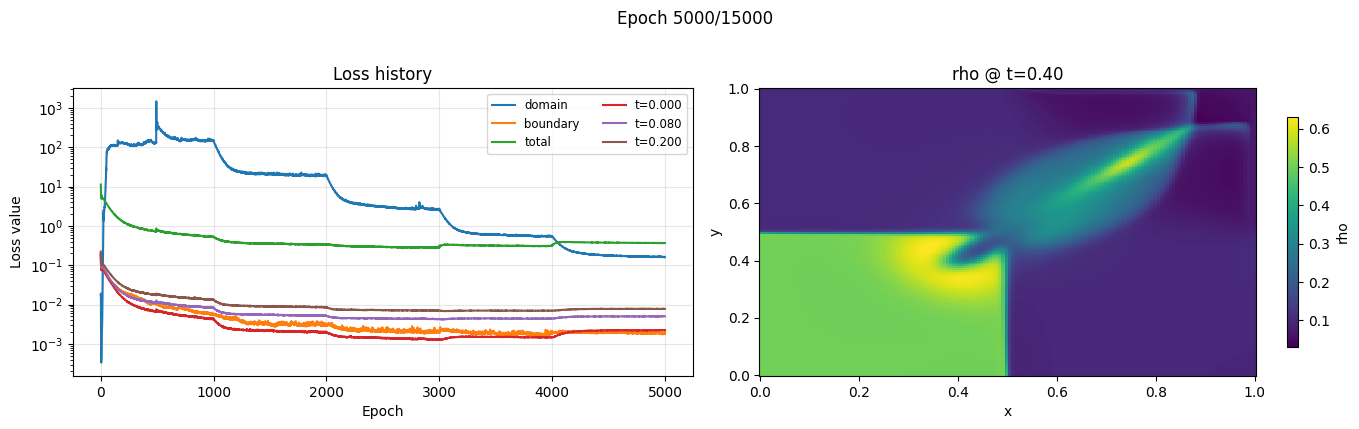

Epoch 5000/15000 - domain: 1.605e-01, boundary: 1.937e-03, t=0.000: 2.232e-03, t=0.080: 5.062e-03, t=0.200: 7.817e-03, total: 3.684e-01


KeyboardInterrupt: 

In [28]:
for epoch in range(1, epochs + 1):


    model.train()
    optimizer.zero_grad()

    # batches 
    coords_domain = sample_domain(n_domain)
    domain_loss_sum = 0.0
    total_domain_elems = None
    for chunk in torch.split(coords_domain, DOMAIN_MB):
        preds_domain = model(chunk)
        residual = jacobian_residual(preds_domain, chunk)
        if total_domain_elems is None:
            total_domain_elems = n_domain * residual.shape[1]
        chunk_elems = residual.numel()
        loss_chunk = F.mse_loss(residual, torch.zeros_like(residual), reduction="mean")
        (lambda_domain * loss_chunk * (chunk_elems / total_domain_elems)).backward()
        domain_loss_sum += loss_chunk.detach() * chunk_elems
    domain_loss = domain_loss_sum / total_domain_elems

    #Data / boundary terms 
    x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    y_data = torch.rand(n_intermediate, 1, device=DEVICE) * (Y_DOMAIN[1] - Y_DOMAIN[0]) + Y_DOMAIN[0]
    xy_data = torch.cat([x_data, y_data], dim=1)

    data_losses = {}
    total_loss_rest = 0.0
    for t in condition_times:
        t_tensor = torch.full((n_intermediate, 1), t, device=DEVICE)
        coords_data = torch.cat([xy_data, t_tensor], dim=1)
        preds_data = model(coords_data)
        targets_data = cond(t, xy_data, device=DEVICE)
        data_loss = F.mse_loss(preds_data, targets_data)
        data_losses[f"t={t:.3f}"] = data_loss
        total_loss_rest = total_loss_rest + lambda_time[t] * data_loss

    x_b, y_b = prepare_boundary_points(n_boundary)
    xy_boundary = torch.cat([x_b, y_b], dim=1)
    t_boundary = torch.rand(n_boundary, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]
    coords_boundary = torch.cat([xy_boundary, t_boundary], dim=1)

    preds_boundary = model(coords_boundary)
    targets_boundary = cond(0.0, xy_boundary, device=DEVICE)
    boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
    total_loss_rest = total_loss_rest + lambda_bdy * boundary_loss

    total_loss = lambda_domain * domain_loss + total_loss_rest  # for logging
    total_loss_rest.backward()

    if grad_clip is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()


    if epoch % schedule_epoch == 0:
        n_domain *= 2
        n_intermediate = max(1024, n_intermediate - 256)
        if lambda_domain_idx < len(lambda_domain_sch):
            lambda_domain = lambda_domain_sch[lambda_domain_idx]
            lambda_domain_idx += 1
        lrg *= lrg_decay
        for group in optimizer.param_groups:
            group["lr"] = lrg

    log_history(loss_history, "domain", domain_loss)
    for key, loss_value in data_losses.items():
        log_history(loss_history, key, loss_value)
    log_history(loss_history, "boundary", boundary_loss)
    log_history(loss_history, "total", total_loss)

    if epoch % 50 == 0 or epoch == 1:
        clear_output(wait=True)
        plot_training_progress(loss_history, model, epoch, epochs)
        latest_losses = {
            "domain": loss_history["domain"][-1],
            "boundary": loss_history["boundary"][-1],
            **{k: loss_history[k][-1] for k in data_losses},
            "total": loss_history["total"][-1],
        }
        print(
            f"Epoch {epoch}/{epochs} - "
            + ", ".join(f"{name}: {value:.3e}" for name, value in latest_losses.items())
        )



/var/folders/jk/_xl3d2hs5x36rpykc1vsg8m40000gq/T/ipykernel_32859/3880432056.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.86, 0.98])


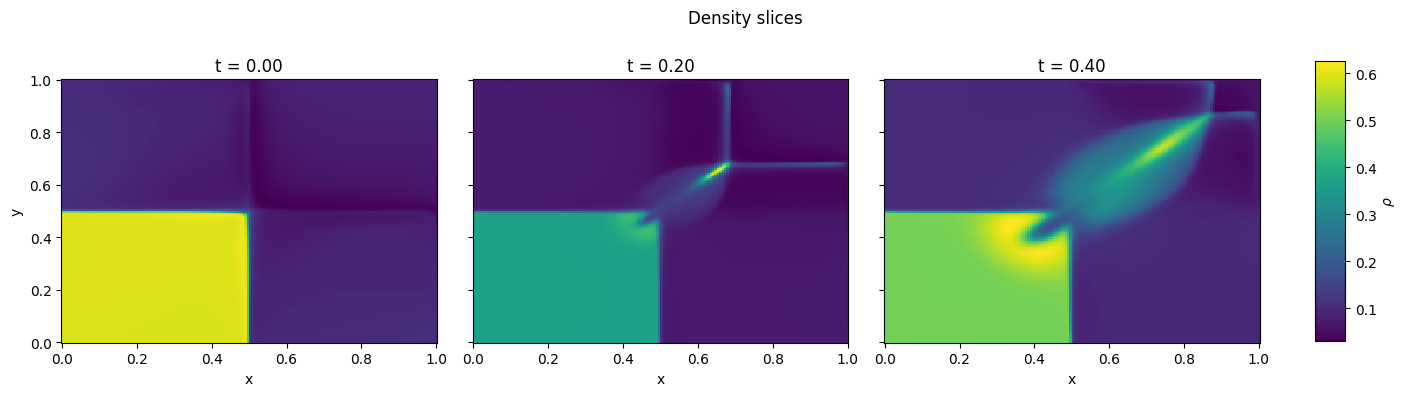

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rho_times(model, times=(0.0, 0.2, 0.4), nx=160, ny=160):
    model.eval()
    x = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], nx, device=DEVICE)
    y = torch.linspace(Y_DOMAIN[0], Y_DOMAIN[1], ny, device=DEVICE)
    X, Y = torch.meshgrid(x, y, indexing="ij")

    fig, axes = plt.subplots(1, len(times), figsize=(5 * len(times), 4), sharex=True, sharey=True)
    if len(times) == 1:
        axes = np.array([axes])  # ensure array-like for consistent indexing

    with torch.no_grad():
        pcm = None
        for ax, t_val in zip(axes, times):
            T = torch.full_like(X, fill_value=t_val)
            coords = torch.stack([X, Y, T], dim=-1).reshape(-1, 3)
            rho = model(coords)[:, 0].reshape(nx, ny).cpu()

            pcm = ax.pcolormesh(
                X.cpu().numpy(),
                Y.cpu().numpy(),
                rho.numpy(),
                shading="auto",
                cmap="viridis",
            )
            ax.set_title(f"t = {t_val:.2f}")
            ax.set_xlabel("x")
        axes[0].set_ylabel("y")

    fig.subplots_adjust(right=0.85)
    cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(pcm, cax=cax, label=r"$\rho$")
    fig.suptitle("Density slices")
    fig.tight_layout(rect=[0, 0, 0.86, 0.98])
    model.train()

plot_rho_times(model, times=(0.0, 0.2, 0.4))
